# Semantic Search: Baseline vs Fine-Tuning Comparison

**Goal:** Compare semantic search quality before and after fine-tuning using three approaches:

1. **Baseline**: Embedding search with FAISS (no fine-tuning)
2. **Contrastive Fine-Tuning**: Improve embeddings directly using contrastive learning
3. **LoRA Reranking**: Train a lightweight LoRA adapter on a small LLM to rerank FAISS results

We'll evaluate each approach using standard information retrieval metrics:
- **Hit@K**: Did we find at least one relevant document in the top K results?
- **MRR (Mean Reciprocal Rank)**: How high is the first relevant result ranked?
- **nDCG (Normalized Discounted Cumulative Gain)**: How well are relevant documents ranked overall?

Additionally, we'll test how each approach affects **downstream LLM performance** by using retrieved documents as context for question answering.

## Theoretical Background

### What is Semantic Search?

Traditional keyword search matches exact words, but **semantic search** understands the *meaning* behind queries and documents. For example:
- Query: "Who discovered the first antibiotic?"
- Relevant document: "Alexander Fleming found penicillin in 1928"

Notice that the words "discovered," "first," and "antibiotic" don't appear exactly in the document, but the meaning matches.

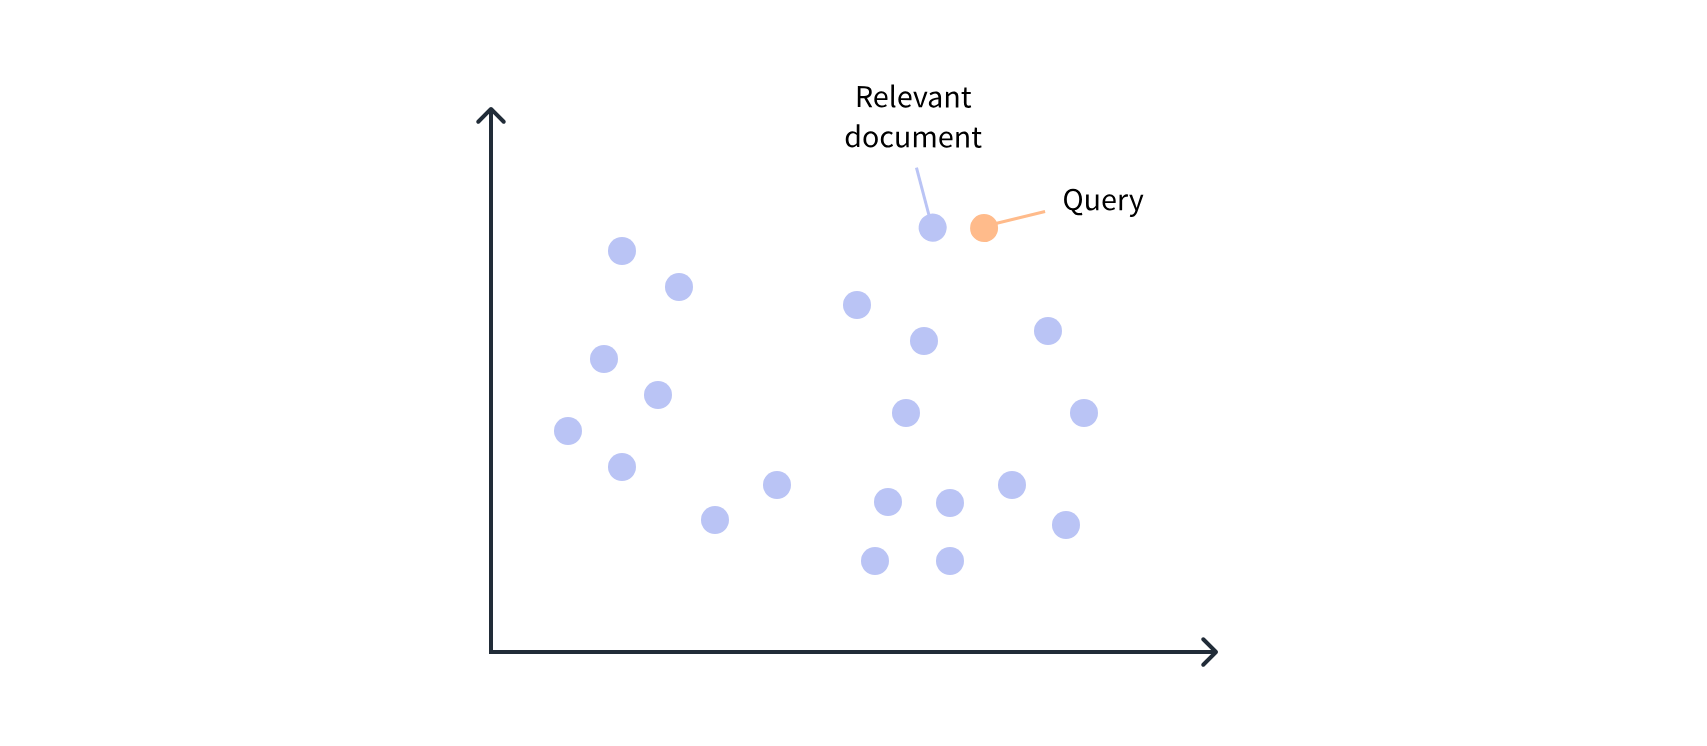

### How Does Semantic Search Work?

**Step 1: Embedding**
- Convert text into dense vectors (arrays of numbers) that capture semantic meaning
- Similar meanings → similar vectors (close in vector space)
- Example: "dog" and "puppy" have similar embeddings, but "dog" and "car" don't

**Step 2: Indexing**
- Store all document embeddings in a searchable index (we use FAISS)
- FAISS enables fast similarity search over millions of vectors

**Step 3: Retrieval**
- Embed the query using the same model
- Find documents with embeddings most similar to the query embedding
- Similarity is typically measured using cosine similarity or dot product

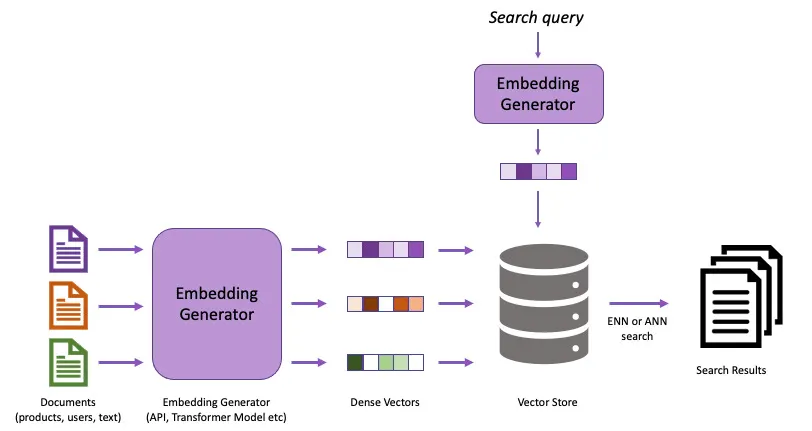

### Why Fine-Tune?

Pre-trained models are general-purpose, but your specific task might need:
- **Domain adaptation**: Medical, legal, or technical terminology
- **Task-specific relevance**: What "relevant" means in your context
- **Better ranking**: Distinguishing between somewhat relevant and highly relevant

### Two Fine-Tuning Approaches

**1. Contrastive Fine-Tuning (Embedding Level)**
- Modifies the embedding model itself
- Learns to pull similar items together and push dissimilar items apart
- Fast at inference (just embedding + similarity search)
- Changes the entire corpus representation

**2. LoRA Reranking (Model Level)**
- Keeps embeddings unchanged
- Trains a language model to score query-document pairs
- Slower at inference (must score each candidate)
- Can capture complex relevance patterns that embeddings miss

## Setup and Installation

First, let's install the required packages.

In [ ]:
!pip install -q sentence-transformers faiss-cpu transformers peft torch accelerate datasets

## 1. Dataset Preparation

### Theory: What Makes Good Training Data?

For semantic search, we need:
1. **Queries**: What users actually search for
2. **Documents**: The content we're searching through
3. **Relevance labels**: Which documents answer which queries

**Positive pairs**: (query, relevant document) - these should have high similarity

**Negative pairs**: (query, irrelevant document) - these should have low similarity

The quality of your training data directly impacts fine-tuning success. In production:
- Use real user queries (not synthetic ones)
- Include hard negatives (documents that seem relevant but aren't)
- Balance positive and negative examples
- Cover diverse query types

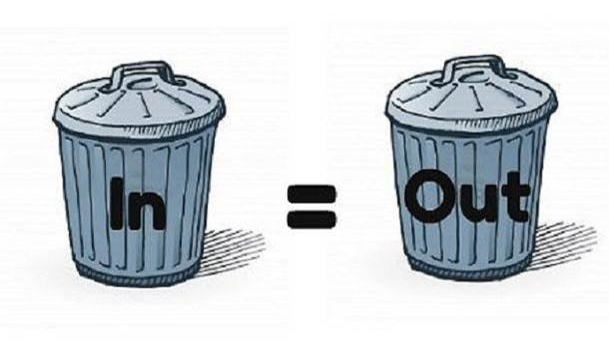

In [ ]:
import numpy as np
import torch
from typing import List, Tuple

Use this prompt:
> Create a Python list named corpus containing about 15 short, factual sentences suitable for a semantic search exercise.
The sentences should cover diverse topics such as science, history, geography, and famous discoveries.
Include examples about antibiotics, DNA, Nobel Prizes, and major cities.
Make sure each sentence is unique, factual, and written in clear, concise English.
Output only the Python code defining the list variable (no explanations, no extra text).

In [ ]:
## Paste the LLM output

In [ ]:
# Test queries with known relevant document indices
# These represent real information needs
test_queries = [
    {
        "query": __ ,
        "relevant": __
    },
    {
        "query": __ ,
        "relevant": __
    },
    {
        "query": __ ,
        "relevant": __
    },
    {
        "query": __ ,
        "relevant": __
    },
    {
        "query": __ ,
        "relevant": __
    },
]

In [ ]:
print(f"Corpus size: {len(corpus)} documents")
print(f"Test queries: {len(test_queries)} queries")
print(f"\nExample query: '{test_queries[0]['query']}'")
print(f"Relevant docs: {[corpus[i][:60] + '...' for i in test_queries[0]['relevant']]}")

## 2. Evaluation Metrics

### Theory: Why Multiple Metrics?

No single metric captures all aspects of search quality. Each metric answers a different question:

**Hit@K**: "Did we find anything useful?" (binary success/failure)
- Simple, intuitive
- Good for minimum quality thresholds
- Doesn't distinguish between finding 1 or all relevant docs

**MRR (Mean Reciprocal Rank)**: "How quickly do users find what they need?"
- Focuses on the first relevant result
- Reflects real user behavior (most users check top results first)
- Important for question answering and single-answer queries

**nDCG (Normalized Discounted Cumulative Gain)**: "How good is the overall ranking?"
- Most comprehensive metric
- Considers all relevant documents and their positions
- Standard in academic research
- Best for multi-document relevance scenarios

### Mathematical Foundations

**Cosine Similarity** (used in FAISS):
```
similarity(A, B) = (A · B) / (||A|| × ||B||)
```
For normalized vectors: `similarity(A, B) = A · B` (dot product)

**Reciprocal Rank**:
```
RR = 1 / rank_of_first_relevant_document
```

**Discounted Cumulative Gain**:
```
DCG@K = Σ(relevance_i / log₂(i + 1)) for i = 1 to K
```
The logarithmic discount means position matters: rank 1 is much better than rank 10.

Example: Amazon Search

Let’s imagine a user searches on Amazon for **"wireless headphones"**.  
The system returns the following **top 5 results**, and the **relevant ones** (that truly match what the user wanted) are marked ✅.

| Rank | Product Name | Relevant? |
|------|---------------|-----------|
| 1 | Bluetooth Speaker | ❌ |
| 2 | Wireless Headphones (Brand A) | ✅ |
| 3 | Wired Headphones | ❌ |
| 4 | Wireless Earbuds (Brand B) | ✅ |
| 5 | Phone Case | ❌ |

### 1. Hit@K (Hit Rate at K)
Measures **whether at least one relevant item appears in the top K results**.  
It’s **1 (hit)** if there’s a relevant product within the top K, otherwise **0 (miss)**.

**Example:**
- **Hit@1:** Top 1 item is *not* relevant → **0**
- **Hit@3:** There *is* a relevant item (rank 2) → **1**
- **Hit@5:** There are relevant items (ranks 2 & 4) → **1**

👉 **Hit@1 = 0**, **Hit@3 = 1**, **Hit@5 = 1**

### 2. MRR (Mean Reciprocal Rank)
Focuses on the **position of the first relevant result**.
Here, the **first relevant result** is at rank 2:

```
MRR = 1 / rank of first relevant result = 1 / 2 = 0.5
```

If the relevant item were ranked first, MRR would be 1.  
👉 **MRR = 0.5**

### 3. nDCG (Normalized Discounted Cumulative Gain)
Measures **ranking quality**, giving **higher importance to relevant items near the top**.

```
DCG@K = Σ(relevance_i / log₂(i + 1)) for i = 1 to K
```
where rel_i = 1 if item *i* is relevant, else 0.

For this list:
- Rank 2 → rel = 1, 1/log_2(3) = 0.63
- Rank 4 → rel = 1, 1/log_2(5) = 0.43

```
DCG = 0.63 + 0.43 = 1.06
```

**Ideal DCG (IDCG)** = if both relevant items were at ranks 1 & 2:

```
IDCG = 1 + 1/log_2(3) = 1 + 0.63 = 1.63
```

```
nDCG = DCG/IDCG = 1.06/1.63 = 0.65
```

👉 **nDCG = 0.65**

Summary

| Metric | Meaning | Value |
|--------|----------|--------|
| **Hit@3** | Any relevant item in top 3? | ✅ (1) |
| **MRR** | How early is the first relevant item? | 0.5 |
| **nDCG** | How well are all relevant items ranked? | 0.65 |

In [ ]:
def hit_at_k(retrieved_indices: List[int], relevant_indices: List[int], k: int) -> float:
    """
    Hit@K: Returns 1 if at least one relevant document appears in top K results, 0 otherwise.

    This is a binary metric - either we found something relevant or we didn't.
    It's the most forgiving metric: even if relevant docs are ranked poorly,
    as long as one appears in top K, we get full credit.
    """
    top_k = retrieved_indices[:k]
    return 1.0 if any(idx in relevant_indices for idx in top_k) else 0.0


def mrr(retrieved_indices: List[int], relevant_indices: List[int]) -> float:
    """
    Mean Reciprocal Rank (MRR): Returns 1/rank of the first relevant document.

    Examples:
    - First result is relevant: MRR = 1/1 = 1.0 (perfect)
    - Second result is relevant: MRR = 1/2 = 0.5
    - Third result is relevant: MRR = 1/3 = 0.333
    - No relevant results: MRR = 0.0

    Higher is better. Rewards systems that rank relevant documents higher.
    This metric reflects real user behavior: users typically scan results from top to bottom.
    """
    for rank, idx in enumerate(retrieved_indices, start=1):
        if idx in relevant_indices:
            return 1.0 / rank
    return 0.0


def dcg_at_k(retrieved_indices: List[int], relevant_indices: List[int], k: int) -> float:
    """
    Discounted Cumulative Gain (DCG): Sum of relevance scores discounted by position.

    Formula: DCG = sum(rel_i / log2(i + 1)) for i in 1..k

    The log discount means documents at lower positions contribute less to the score.
    Position 1: discount = 1.0 (no discount)
    Position 2: discount = 0.63 (1/log2(3))
    Position 3: discount = 0.50 (1/log2(4))
    Position 10: discount = 0.30 (1/log2(11))

    This reflects diminishing returns: moving from rank 10 to 9 matters less than 2 to 1.
    """
    dcg = 0.0
    for i, idx in enumerate(retrieved_indices[:k], start=1):
        if idx in relevant_indices:
            # Binary relevance: 1 if relevant, 0 if not
            # Can be extended to graded relevance (e.g., 0-3 scale)
            dcg += 1.0 / np.log2(i + 1)
    return dcg


def ndcg(retrieved_indices: List[int], relevant_indices: List[int], k: int = None) -> float:
    """
    Normalized Discounted Cumulative Gain (nDCG): DCG normalized by ideal DCG.

    nDCG = DCG / IDCG, where IDCG is the DCG of the perfect ranking.

    Range: [0, 1], where 1.0 means perfect ranking of all relevant documents.

    Normalization makes nDCG comparable across queries with different numbers
    of relevant documents. A query with 1 relevant doc and one with 10 relevant
    docs can both achieve nDCG = 1.0 if perfectly ranked.

    This metric considers both:
    1. Whether relevant documents are retrieved
    2. How highly they are ranked
    """
    if k is None:
        k = len(retrieved_indices)

    # Actual DCG
    actual_dcg = dcg_at_k(retrieved_indices, relevant_indices, k)

    # Ideal DCG: what if all relevant docs were at the top?
    ideal_ranking = relevant_indices + [i for i in range(len(corpus)) if i not in relevant_indices]
    ideal_dcg = dcg_at_k(ideal_ranking, relevant_indices, k)

    if ideal_dcg == 0:
        return 0.0

    return actual_dcg / ideal_dcg

Test the metrics with some examples:

In [ ]:
# Perfect ranking: relevant docs are [0, 1, 2]
perfect = __
print(f"Perfect ranking: {perfect}")
print(f"  Hit@3: {hit_at_k(perfect, [0, 1, 2], 3):.3f} ← Found relevant docs")
print(f"  MRR: {mrr(perfect, [0, 1, 2]):.3f} ← First result is relevant (1/1)")
print(f"  nDCG: {ndcg(perfect, [0, 1, 2], 5):.3f} ← Perfect ranking\n")

In [ ]:
# Good ranking: first relevant at position 2
good = __
print(f"Good ranking: {good}")
print(f"  Hit@3: {hit_at_k(good, [0, 1, 2], 3):.3f} ← Found relevant docs")
print(f"  MRR: {mrr(good, [0, 1, 2]):.3f} ← First relevant at position 2 (1/2)")
print(f"  nDCG: {ndcg(good, [0, 1, 2], 5):.3f} ← Good but not perfect\n")

In [ ]:
# Poor ranking: first relevant at position 4
poor = __
print(f"Poor ranking: {poor}")
print(f"  Hit@3: {hit_at_k(poor, [0, 1, 2], 3):.3f} ← No relevant docs in top 3")
print(f"  MRR: {mrr(poor, [0, 1, 2]):.3f} ← First relevant at position 4 (1/4)")
print(f"  nDCG: {ndcg(poor, [0, 1, 2], 5):.3f} ← Poor ranking")

## 3. Baseline: FAISS Semantic Search (No Fine-Tuning)

### Theory: How FAISS Works

**FAISS** (Facebook AI Similarity Search) is a library for efficient similarity search.

**IndexFlatIP** (Inner Product):
- Stores vectors as-is without compression
- Performs exact search (no approximation)
- For normalized vectors, inner product = cosine similarity
- Fast for small datasets (<100K vectors)

**Search Process**:
1. Encode query into a vector
2. Compute similarity with all corpus vectors
3. Return top-K most similar documents

**Why Start with Baseline?**
- Establishes performance floor
- Often "good enough" for general-purpose search
- Fast and requires no training
- Provides comparison point for fine-tuned models

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss

# Load pre-trained model
# all-MiniLM-L6-v2: Fast, 384-dimensional embeddings, trained on 1B+ sentence pairs
print("Loading pre-trained model...")
baseline_model = __

**What are vector embedding models?**
These are neural networks trained to map text into a numerical space where similar meanings cluster together. Choosing the right model depends on task, language support, input size, and compute constraints.

| Model name          | Type                    | Languages | Strengths                                 | Typical dimension |
|--------------------|------------------------|-----------|-------------------------------------------|-------------------|
| all-MiniLM-L6-v2   | SentenceTransformer     | multi     | Speed, good general-purpose performance   | 384               |
| paraphrase-mpnet   | SentenceTransformer     | multi     | Accuracy, larger vector size              | 768               |
| cohere-embed-v3    | Cohere API/SDK          | multi     | Compression-aware, fast, SOTA benchmarks  | ~1024             |
| OpenAI Ada-002/3   | OpenAI API              | multi     | Cost-effective, very accurate             | 1536–3072         |
| E5-mistral-7b      | Transformers, open-src  | multi     | Large, strong on instruction following    | 1024 or 4096      |
| BGE                | BAAI, HuggingFace       | multi     | Performance on noisy data                 | 768–1024          |
| SBERT variants     | HuggingFace             | multi     | Many tasks, pre-trained/fine-tuned        | 384–768           |

**Selection advice:**
- Start with well-supported, lighter models like `all-MiniLM-L6-v2` or Cohere v3.
- Use larger models (OpenAI, Mistral, BigScience) for higher recall/precision or complex queries.
- Multilingual tasks: check coverage in model card.

**Notes on model selection:**
- Higher dimension ≠ always better; increases storage/computation, but allows more precise mapping for complex or dense search spaces.
- Some APIs (OpenAI, Cohere) charge per token/dimension—be mindful of throughput and cost.
- HuggingFace and Cohere host diverse, benchmarked embedding models for instant use.

In [ ]:
# 1. Create the embeddings

baseline_embeddings = baseline_model.__(
    __, ## What do we encode?
    convert_to_numpy=True,
    normalize_embeddings=True,  # Critical for using Inner Product as cosine similarity
    show_progress_bar=True
)

**Why a vector database?**
- Embedding lookup (nearest neighbor search) in large datasets is too slow for standard RDBMS/SQL
- Vector DBs (OpenSearch, FAISS, Milvus) allow sub-second retrieval with optimized vector search algorithms (HNSW, IVF, PQ).

**Common Vector Database Options:**
| Database        | Open Source | Scaling         | Ranking Method         | Python Support  |
|-----------------|-------------|-----------------|-----------------------|-----------------|
| FAISS           | Yes         | CPU/GPU, Local  | L2 / Cosine / DotPr   | Yes             |
| OpenSearch      | Yes         | Cloud/Cluster   | L2 / Cosine / DotPr   | Yes             |
| Milvus          | Yes         | Distributed     | IVF/HNSW/Flat/PQ ...  | Yes             |
| Pinecone/Vespa  | (Pinecone: S) | Managed      | Various               | Yes             |

In [ ]:
# 2. Build FAISS index (Inner Product = Cosine Similarity for normalized vectors)

dimension = baseline_embeddings.shape[1]  # 384 for all-MiniLM-L6-v2
baseline_index = faiss.IndexFlatIP(dimension)  # IP = Inner Product
baseline_index.add(baseline_embeddings.astype('float32'))  # FAISS requires float32

print(f"\nIndex built with {baseline_index.ntotal} vectors of dimension {dimension}")
print(f"Memory usage: ~{baseline_index.ntotal * dimension * 4 / 1024:.2f} KB")

In [ ]:
# 3. Define search function

def search_baseline(query: str, top_k: int = 5) -> List[Tuple[int, float, str]]:
    """
    Search using baseline FAISS index.
    Returns: List of (index, score, text) tuples
    """

    query_embedding = # INSERT YOUR CODE HERE
    scores, indices = # INSERT YOUR CODE HERE

    results = []
    for score, idx in zip(scores[0], indices[0]):
        if idx != -1:  # FAISS returns -1 for empty slots (when top_k > corpus size)
            results.append((int(idx), float(score), corpus[idx]))

    return results

In [ ]:
# 4. Test baseline search

test_query = test_queries[0] ## Try with other queries
print(f"Query: '{test_query['query']}'\n")
print("Baseline Results:")
print("=" * 80)

results = search_baseline(test_query['query'], top_k=5)
for idx, score, text in results:
    relevant_marker = "✓" if idx in test_query['relevant'] else "✗"
    print(f"{relevant_marker} [{idx}] Score: {score:.4f}")
    print(f"   {text}\n")

### Baseline Results Analysis

**What to look for:**
- Are relevant documents (marked with ✓) appearing in the results?
- What are their positions? (Higher is better)
- What are the similarity scores? (Closer to 1.0 is better)
- Are irrelevant documents (marked with ✗) scoring high? (This indicates the model doesn't understand domain-specific relevance)

**Common patterns:**
- **Good baseline**: Relevant docs appear in top 3 with scores > 0.5
- **Weak baseline**: Relevant docs appear but ranked low, or scores are similar for relevant and irrelevant docs
- **Poor baseline**: No relevant docs in top 5 (suggests embeddings don't capture the domain well)

### Evaluate Baseline Performance

In [ ]:
def evaluate_retrieval(search_fn, queries, k=5):
    """
    Evaluate a search function on multiple queries.
    Computes average metrics across all queries.
    """
    hits = []
    mrrs = []
    ndcgs = []

    for q in queries:
        results = search_fn(q['query'], top_k=k)
        retrieved_indices = [idx for idx, _, _ in results]

        hits.append(hit_at_k(retrieved_indices, q['relevant'], k))
        mrrs.append(mrr(retrieved_indices, q['relevant']))
        ndcgs.append(ndcg(retrieved_indices, q['relevant'], k))

    return {
        'hit_at_k': np.mean(hits),
        'mrr': np.mean(mrrs),
        'ndcg': np.mean(ndcgs)
    }

In [ ]:
# 5. Evaluate the results for all the queries

baseline_metrics = evaluate_retrieval(__, __, k=5)

In [ ]:
print("Baseline Performance (No Fine-Tuning):")
print("=" * 40)
print(f"Hit@5:  {baseline_metrics['hit_at_k']:.3f}")
print(f"MRR:    {baseline_metrics['mrr']:.3f}")
print(f"nDCG@5: {baseline_metrics['ndcg']:.3f}")

print("\n📊 Interpretation:")
if baseline_metrics['hit_at_k'] >= 0.8:
    print("✓ Hit@5 is good - system finds relevant docs for most queries")
else:
    print("✗ Hit@5 is low - system struggles to find relevant docs")

if baseline_metrics['mrr'] >= 0.7:
    print("✓ MRR is good - relevant docs typically appear in top 2")
elif baseline_metrics['mrr'] >= 0.5:
    print("~ MRR is moderate - relevant docs appear around position 2-3")
else:
    print("✗ MRR is low - relevant docs are ranked too low")

if baseline_metrics['ndcg'] >= 0.8:
    print("✓ nDCG is excellent - overall ranking quality is high")
elif baseline_metrics['ndcg'] >= 0.6:
    print("~ nDCG is good - ranking is decent but has room for improvement")
else:
    print("✗ nDCG is low - ranking quality needs significant improvement")

### Test: LLM Question Answering with Baseline Retrieval

Now let's see how well an LLM can answer questions using the retrieved context from the baseline approach.

**Hypothesis**: Better retrieval → Better answers

We'll use the retrieved documents as context for the LLM to answer the question.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

In [ ]:
# 6. Load a small LLM for question answering

qa_model_name = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'
print(f"Loading {qa_model_name} for question answering...")

qa_tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
qa_tokenizer.pad_token = qa_tokenizer.eos_token

qa_model = AutoModelForCausalLM.from_pretrained(
    qa_model_name,
    torch_dtype=torch.float16 if device == 'cuda' else torch.float32,
    device_map='auto' if device == 'cuda' else None
)

if device == 'cpu':
    qa_model = qa_model.to(device)

print("Model loaded successfully!\n")

In [ ]:
# 7. Define question&answer function

def answer_question_with_context(question: str, context_docs: List[str], max_new_tokens: int = 100) -> str:
    """
    Answer a question using retrieved documents as context.

    This simulates a RAG (Retrieval-Augmented Generation) system:
    1. Retrieve relevant documents (already done)
    2. Use them as context for the LLM
    3. Generate an answer based on the context
    """

    # INSERT CODE HERE

    return answer

In [ ]:
# Test with baseline retrieval
test_question = __ ## Write your question
print(f"Question: {test_question}\n")

# Retrieve context using baseline
baseline_results = search_baseline(__, top_k=3) ## Input the question to retrieve answer
baseline_context = [text for _, _, text in baseline_results] ## Don't change this

print("Retrieved Context (Baseline):")
print("-" * 80)
for i, (idx, score, text) in enumerate(baseline_results, 1):
    print(f"[{i}] Score: {score:.4f} | Doc [{idx}]")
    print(f"    {text}\n")

In [ ]:
# Generate answer
baseline_answer = answer_question_with_context(__, __) ## What inputs? Hint: question and context

print("LLM Answer (using Baseline retrieval):")
print("=" * 80)
print(baseline_answer)
print("=" * 80)

### Analysis: Baseline LLM Answer

**What to evaluate:**
1. **Correctness**: Does the answer correctly identify Alexander Fleming?
2. **Completeness**: Does it mention penicillin and the year (1928)?
3. **Context quality**: Did the retrieved documents contain the necessary information?

**Expected patterns:**
- If relevant docs are in top 3: Answer should be accurate and complete
- If relevant docs are missing: Answer may be vague, incorrect, or say "I don't know"
- If irrelevant docs dominate: Answer may be off-topic or confused

**Key insight**: The LLM is only as good as the context we provide. Poor retrieval → Poor answers, regardless of LLM quality.

## 4. Approach 1: Contrastive Fine-Tuning

### Theory: Contrastive Learning

**Goal**: Teach the embedding model what "relevant" means in your specific context.

**How it works:**
1. **Positive pairs** (query, relevant doc): Pull their embeddings closer together
2. **Negative pairs** (query, irrelevant doc): Push their embeddings further apart

**Mathematical intuition:**
```
Loss = (predicted_similarity - target_similarity)²

For positive pairs: target = 1.0 (maximize similarity)
For negative pairs: target = 0.0 (minimize similarity)
```

**CosineSimilarityLoss**:
- Computes cosine similarity between embeddings
- Compares it to the target label (0.0 or 1.0)
- Updates model weights to minimize the difference

**Why this works:**
- The model learns domain-specific patterns
- "Antibiotic" and "penicillin" become more similar
- "Antibiotic" and "Eiffel Tower" become less similar
- The entire embedding space is reshaped for your task

**Trade-offs:**
- ✓ Fast inference (same speed as baseline)
- ✓ Improves all queries (not just training ones)
- ✗ Requires rebuilding the entire index
- ✗ May overfit to training domain

In [ ]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader, Dataset

# Create training examples
# Key principle: Show the model what "relevant" and "irrelevant" mean
train_examples = []

query_for_training = __  # "Who discovered the first antibiotic?"
relevant_docs = __ # [0, 1, 2]

# Positive pairs: query with relevant documents (label = 1.0)
# These teach the model: "These should be similar"
for idx in relevant_docs:
    train_examples.append(
        InputExample(texts=[query_for_training, corpus[idx]], label=1.0)
    )

# Negative pairs: query with irrelevant documents (label = 0.0)
# These teach the model: "These should NOT be similar"
irrelevant_docs = [i for i in range(len(corpus)) if i not in relevant_docs]
for idx in irrelevant_docs[:5]:  # Use 5 negative examples
    train_examples.append(
        InputExample(texts=[query_for_training, corpus[idx]], label=0.0)
    )

# Add more training examples from other queries
# More diverse training data → Better generalization
for q in test_queries[1:3]:  # Use queries 1 and 2 for training
    # Positive pairs
    for idx in q['relevant'][:2]:  # Take first 2 relevant docs
        train_examples.append(
            InputExample(texts=[q['query'], corpus[idx]], label=1.0)
        )

    # Negative pairs
    irrelevant = [i for i in range(len(corpus)) if i not in q['relevant']]
    for idx in irrelevant[:3]:  # Take 3 negative examples
        train_examples.append(
            InputExample(texts=[q['query'], corpus[idx]], label=0.0)
        )

print(f"Created {len(train_examples)} training examples")
print(f"  Positive pairs: {sum(1 for ex in train_examples if ex.label == 1.0)}")
print(f"  Negative pairs: {sum(1 for ex in train_examples if ex.label == 0.0)}")
print(f"\nBalance: {sum(1 for ex in train_examples if ex.label == 1.0) / len(train_examples):.1%} positive")
print("(Ideally 30-50% positive for balanced learning)")

In [ ]:
# Clone the baseline model for fine-tuning
print("Preparing model for contrastive fine-tuning...")
finetuned_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create DataLoader
# Batch size: Number of examples processed together
# Larger batch → More stable gradients but more memory
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=4)

# Define loss function
# CosineSimilarityLoss: Minimizes (cosine_sim - target_label)²
train_loss = losses.CosineSimilarityLoss(finetuned_model)

print(f"Training batches: {len(train_dataloader)}")
print(f"Total training steps: {len(train_dataloader) * 3} (3 epochs)\n")

# Fine-tune the model
print("Fine-tuning with contrastive learning...")
print("This will:")
print("  1. Pull similar pairs closer in embedding space")
print("  2. Push dissimilar pairs further apart")
print("  3. Reshape the entire embedding space for this task\n")

__.fit( ## Fine-tune the cloned model
    train_objectives=[(__, __)],
    epochs=3,  # Number of passes through the training data
    warmup_steps=10,  # Gradual learning rate increase at start
    show_progress_bar=True
)

print("\n✓ Fine-tuning complete!")
print("The model has learned domain-specific relevance patterns.")

In [ ]:
# Rebuild FAISS index with fine-tuned embeddings
# Important: We must re-encode ALL documents with the fine-tuned model
print("Rebuilding FAISS index with fine-tuned embeddings...")
print("(This is necessary because the embedding space has changed)\n")

finetuned_embeddings = finetuned_model.encode(
    __, ## What do we encode to build the index?
    convert_to_numpy=True,
    normalize_embeddings=True,
    show_progress_bar=True
)

finetuned_index = faiss.IndexFlatIP(dimension)
finetuned_index.add(finetuned_embeddings.astype('float32'))

print(f"\nIndex rebuilt with {finetuned_index.ntotal} vectors")


def search_finetuned(query: str, top_k: int = 5) -> List[Tuple[int, float, str]]:
    """
    Search using fine-tuned FAISS index.
    """
    query_embedding = finetuned_model.encode(
        [__], ## What do we encode to search?
        convert_to_numpy=True,
        normalize_embeddings=True
    )

    scores, indices = finetuned_index.__(query_embedding.astype('float32'), top_k) ## How do we search?

    results = []
    for score, idx in zip(scores[0], indices[0]):
        if idx != -1:
            results.append((int(idx), float(score), corpus[idx]))

    return results

In [ ]:
# Test fine-tuned search
test_query = test_queries[0]
print(f"Query: '{test_query['query']}'\n")

print("Baseline Results (for comparison):")
print("-" * 80)
baseline_results = search_baseline(test_query['query'], top_k=5)
for idx, score, text in baseline_results:
    relevant_marker = "✓" if idx in test_query['relevant'] else "✗"
    print(f"{relevant_marker} [{idx}] Score: {score:.4f} | {text[:60]}...")

print("\nFine-Tuned Results:")
print("=" * 80)
finetuned_results = search_finetuned(test_query['query'], top_k=5)
for idx, score, text in finetuned_results:
    relevant_marker = "✓" if idx in test_query['relevant'] else "✗"
    print(f"{relevant_marker} [{idx}] Score: {score:.4f} | {text[:60]}...")

print("\n📊 Observations:")
print("Compare the two result sets:")
print("  • Are relevant docs (✓) ranked higher in fine-tuned results?")
print("  • Are the similarity scores more separated (relevant vs irrelevant)?")
print("  • Did any irrelevant docs (✗) get pushed down in ranking?")

### Evaluate Fine-Tuned Performance

In [ ]:
finetuned_metrics = evaluate_retrieval(search_finetuned, test_queries, k=5)

print("Fine-Tuned Performance (Contrastive Learning):")
print("=" * 40)
print(f"Hit@5:  {finetuned_metrics['hit_at_k']:.3f}")
print(f"MRR:    {finetuned_metrics['mrr']:.3f}")
print(f"nDCG@5: {finetuned_metrics['ndcg']:.3f}")

print("\nImprovement over Baseline:")
print("=" * 40)
hit_improvement = finetuned_metrics['hit_at_k'] - baseline_metrics['hit_at_k']
mrr_improvement = finetuned_metrics['mrr'] - baseline_metrics['mrr']
ndcg_improvement = finetuned_metrics['ndcg'] - baseline_metrics['ndcg']

print(f"Hit@5:  {hit_improvement:+.3f} ({(hit_improvement / baseline_metrics['hit_at_k'] * 100) if baseline_metrics['hit_at_k'] > 0 else 0:.1f}%)")
print(f"MRR:    {mrr_improvement:+.3f} ({(mrr_improvement / baseline_metrics['mrr'] * 100) if baseline_metrics['mrr'] > 0 else 0:.1f}%)")
print(f"nDCG@5: {ndcg_improvement:+.3f} ({(ndcg_improvement / baseline_metrics['ndcg'] * 100) if baseline_metrics['ndcg'] > 0 else 0:.1f}%)")

print("\n📊 Analysis:")
if mrr_improvement > 0.1:
    print("✓ Significant MRR improvement - relevant docs are ranked much higher")
elif mrr_improvement > 0:
    print("~ Modest MRR improvement - slight ranking improvement")
else:
    print("✗ No MRR improvement - fine-tuning didn't help ranking")

if ndcg_improvement > 0.1:
    print("✓ Significant nDCG improvement - overall ranking quality improved")
elif ndcg_improvement > 0:
    print("~ Modest nDCG improvement - slight overall improvement")
else:
    print("✗ No nDCG improvement - fine-tuning didn't improve overall ranking")

### Test: LLM Question Answering with Fine-Tuned Retrieval

Let's see if better retrieval leads to better answers.

In [ ]:
# Test with fine-tuned retrieval
# Same question as before to compare results
# test_question = "Who discovered the first antibiotic?"
print(f"Question: {test_question}\n")

# Retrieve context using fine-tuned model
finetuned_results = search_finetuned(test_question, top_k=3)
finetuned_context = [text for _, _, text in finetuned_results]

print("Retrieved Context (Fine-Tuned):")
print("-" * 80)
for i, (idx, score, text) in enumerate(finetuned_results, 1):
    print(f"[{i}] Score: {score:.4f} | Doc [{idx}]")
    print(f"    {text}\n")

# Generate answer
finetuned_answer = answer_question_with_context(__, __) ## Same function, what inputs? Hint: question and context

print("LLM Answer (using Fine-Tuned retrieval):")
print("=" * 80)
print(finetuned_answer)
print("=" * 80)

print("\n📊 Comparison:")
print("-" * 80)
print("Baseline Answer:")
print(baseline_answer)
print("\nFine-Tuned Answer:")
print(finetuned_answer)
print("-" * 80)

print("\n💡 Analysis:")
print("Compare the two answers:")
print("  • Is the fine-tuned answer more accurate?")
print("  • Does it include more relevant details (e.g., penicillin, 1928)?")
print("  • Is it more confident or less hedged?")
print("  • Did better retrieval lead to a better answer?")

## 5. Approach 2: LoRA Reranking

### Two-Stage Retrieval

**Problem**: Embeddings are fast but may miss nuanced relevance signals.

**Solution**: Two-stage approach
1. **Stage 1 (Retrieval)**: Fast embedding search to get candidates (e.g., top 100)
2. **Stage 2 (Reranking)**: Slower but more accurate model to reorder top candidates

**Why this works:**
- Embeddings: Good at broad semantic matching ("antibiotic" ≈ "penicillin")
- LLMs: Good at fine-grained relevance (understanding context, intent, specificity)

**What is LoRA?**
LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning technique. Rather than updating the entire (often massive) model, LoRA introduces small trainable matrices—called adapters—in key locations (usually within the attention modules of transformer models). Only these small adapters are updated during fine-tuning; the backbone model parameters are frozen.

**Why LoRA?**
- Massive reduction in trainable parameters (up to 99%+)
- Fine-tunes models on modest hardware (even consumer GPUs/Colab)
- Fast and avoids catastrophic forgetting/overfitting on small tasks
- Swappable: You can have multiple LoRA "heads" for different domains without duplicating the whole model

**How LoRA works:**
- Each large weight matrix in (say) the attention module is modified as:
$$
W' = W + A \times B
$$
Where $W$ is the (frozen) original weight, and $A$, $B$ are small low-rank matrices trained for the specific task.

```
If W is 1024×1024 and rank r=8:
  Original parameters: 1,048,576
  LoRA parameters: 1024×8 + 8×1024 = 16,384 (1.6% of original)
```

**Benefits:**
- ✓ Much faster training
- ✓ Much less memory
- ✓ Can train on smaller GPUs or CPU
- ✓ Multiple adapters for different tasks

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import re

# Load a small language model
# We'll use the same model as for QA to save memory
model_name = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'
print(f"Preparing {model_name} for LoRA reranking...\n")

# Load model for reranking (separate from QA model)
reranker_tokenizer = AutoTokenizer.from_pretrained(model_name)
reranker_tokenizer.pad_token = reranker_tokenizer.eos_token

llm_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if device == 'cuda' else torch.float32,
    device_map='auto' if device == 'cuda' else None
)

if device == 'cpu':
    llm_model = llm_model.to(device)

# Configure LoRA
# These hyperparameters control the trade-off between capacity and efficiency
lora_config = LoraConfig(
    r=8,  # Rank: Higher = more capacity but slower (typical: 4-16)
    lora_alpha=16,  # Scaling factor: Usually 2×r
    target_modules=['q_proj', 'v_proj'],  # Apply to attention query and value projections
    lora_dropout=0.1,  # Regularization to prevent overfitting
    bias='none',  # Don't train bias terms
    task_type=TaskType.CAUSAL_LM  # Causal language modeling task
)

# Apply LoRA to the model
# This adds small trainable matrices while freezing the original weights
llm_model = get_peft_model(llm_model, lora_config)

print("LoRA Configuration:")
llm_model.print_trainable_parameters()
print("\nNote: Only ~1% of parameters are trainable!")

### Reranking Task

We train the LLM to score query-document relevance:
```
Input: "Query: [query] Document: [document] Relevance Score: "
Output: A score between 0.0 (irrelevant) and 1.0 (highly relevant)
```

The model learns:
- Semantic matching (like embeddings)
- Contextual understanding (better than embeddings)
- Fine-grained distinctions (somewhat relevant vs highly relevant)

Use this prompt:
> Write a Python function named format_reranking_prompt that prepares a text prompt for a reranking model.
The function should:
> - Take a query string, a document string, and an optional score (float).
> - Return a formatted string that includes system and user tags (<|system|>, <|user|>).
> - The system message should instruct the model to output a relevance score between 0.0 and 1.0 based on how relevant the document is to the query.
> - If a score is provided, append it formatted to two decimal places.
> - Include a short docstring explaining the purpose of the function.

> Output only the complete Python code — no explanations or extra text.

In [ ]:
## Paste the LLM response

In [ ]:
# Create training data for LoRA reranking
lora_train_texts = []

# Use the same queries as before
# Key: We need to show the model examples of relevant (score=0.95) and irrelevant (score=0.05) pairs
for q in test_queries[:3]:  # Use first 3 queries for training
    # Positive examples: relevant documents get high scores
    for idx in q['relevant'][:2]:
        lora_train_texts.append(
            format_reranking_prompt(q['query'], corpus[idx], score=__)
        )

    # Negative examples: irrelevant documents get low scores
    irrelevant = [i for i in range(len(corpus)) if i not in q['relevant']]
    for idx in irrelevant[:2]:
        lora_train_texts.append(
            format_reranking_prompt(q['query'], corpus[idx], score=__)
        )

print(f"Created {len(lora_train_texts)} training prompts for LoRA")
print(f"\nExample training prompt:")
print("-" * 80)
print(lora_train_texts[0])
print("-" * 80)
print("\nThe model will learn to generate '0.95' for relevant pairs and '0.05' for irrelevant pairs.")

In [ ]:
# Tokenize training data
# This converts text into numerical tokens that the model can process
tokenized_data = reranker_tokenizer(
    __, ## We need to pass the training data
    truncation=True,
    padding='max_length',
    max_length=512,  # Maximum sequence length
    return_tensors='pt'
)

In [ ]:
# Create a simple dataset
class RerankerDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        # For causal LM, labels are the same as input_ids
        # The model learns to predict the next token (including the score)
        item['labels'] = item['input_ids'].clone()
        return item

train_dataset = RerankerDataset(tokenized_data)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./lora_reranker',
    per_device_train_batch_size=2,  # Small batch size for memory efficiency
    num_train_epochs=3,  # Number of passes through training data
    logging_steps=5,
    save_strategy='no',  # Don't save checkpoints (saves disk space)
    report_to='wandb',  # "none" if you don't want to report to wandb/tensorboard
    learning_rate=2e-4,  # Learning rate for LoRA (typically higher than full fine-tuning)
    warmup_steps=10,  # Gradual learning rate warmup
)

# Create trainer
trainer = Trainer(
    model=llm_model,
    args=training_args,
    train_dataset=__, ## Name of the train dataset
)

# Train
print("\nTraining LoRA reranker...")
print("This teaches the LLM to score query-document relevance.\n")
trainer.train()
print("\n✓ LoRA training complete!")
print("The model can now score how relevant a document is to a query.")

In [ ]:
# Save trained model
trainer.model.save_pretrained('test_lora')

In [ ]:
def score_with_lora(query: str, document: str, max_new_tokens: int = 10) -> float:
    """
    Score a query-document pair using the LoRA-tuned model.

    Returns a relevance score between 0.0 and 1.0.
    """
    prompt = format_reranking_prompt(query, document)
    inputs = reranker_tokenizer(prompt, return_tensors='pt').to(llm_model.device)

    with torch.no_grad():
        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # Deterministic generation
            pad_token_id=reranker_tokenizer.eos_token_id
        )

    generated_text = reranker_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the score from the generated text
    # Look for a number between 0 and 1 after "Relevance Score:"
    try:
        score_part = generated_text.split('Relevance Score:')[-1].strip()
        match = re.search(r'([0-1](?:\.\d+)?)', score_part)
        if match:
            score = float(match.group(1))
            return max(0.0, min(1.0, score))  # Clamp to [0, 1]
    except:
        pass

    # Default to 0.5 if we can't parse a score
    return 0.5


def search_with_lora_reranking(query: str, top_k: int = 5, rerank_top_n: int = 10) -> List[Tuple[int, float, str]]:
    """
    Search using baseline FAISS, then rerank top results with LoRA model.

    Two-stage process:
    1. Fast retrieval: Get top N candidates from FAISS (e.g., N=10)
    2. Slow reranking: Score each candidate with LoRA and return top K (e.g., K=5)

    Args:
        query: Search query
        top_k: Number of final results to return
        rerank_top_n: Number of FAISS results to rerank (should be >= top_k)
    """
    # Step 1: Get candidates from FAISS (fast)
    candidates = search_baseline(query, top_k=rerank_top_n)

    # Step 2: Rerank with LoRA (slow but accurate)
    reranked = []
    for idx, faiss_score, text in candidates:
        lora_score = score_with_lora(query, text)
        reranked.append((idx, lora_score, text))

    # Step 3: Sort by LoRA score and return top K
    reranked.sort(key=lambda x: x[1], reverse=True)
    return reranked[:top_k]


print("LoRA reranking function ready!")
print("\nHow it works:")
print("  1. FAISS retrieves top 10 candidates (fast, ~milliseconds)")
print("  2. LoRA scores each candidate (slow, ~100ms each)")
print("  3. Return top 5 by LoRA score")
print("\nTotal time: ~1 second (vs ~1ms for FAISS alone)")

In [ ]:
# Compare all three approaches
test_query = test_queries[0]
print(f"Query: '{test_query['query']}'\n")

print("Baseline FAISS Results:")
print("-" * 80)
baseline_results = search_baseline(test_query['query'], top_k=5)
for idx, score, text in baseline_results:
    relevant_marker = "✓" if idx in test_query['relevant'] else "✗"
    print(f"{relevant_marker} [{idx}] Score: {score:.4f} | {text[:60]}...")

print("\nFine-Tuned Results:")
print("-" * 80)
finetuned_results = search_finetuned(test_query['query'], top_k=5)
for idx, score, text in finetuned_results:
    relevant_marker = "✓" if idx in test_query['relevant'] else "✗"
    print(f"{relevant_marker} [{idx}] Score: {score:.4f} | {text[:60]}...")

print("\nLoRA Reranked Results:")
print("=" * 80)
lora_results = search_with_lora_reranking(test_query['query'], top_k=5, rerank_top_n=10)
for idx, score, text in lora_results:
    relevant_marker = "✓" if idx in test_query['relevant'] else "✗"
    print(f"{relevant_marker} [{idx}] LoRA Score: {score:.4f} | {text[:60]}...")

print("\n📊 Observations:")
print("Compare all three approaches:")
print("  • Which approach ranks relevant docs (✓) highest?")
print("  • Are LoRA scores more discriminative than embedding similarities?")
print("  • Did LoRA successfully reorder the FAISS candidates?")

### Evaluate LoRA Reranking Performance

In [ ]:
lora_metrics = evaluate_retrieval(search_with_lora_reranking, test_queries, k=5)

print("LoRA Reranking Performance:")
print("=" * 40)
print(f"Hit@5:  {lora_metrics['hit_at_k']:.3f}")
print(f"MRR:    {lora_metrics['mrr']:.3f}")
print(f"nDCG@5: {lora_metrics['ndcg']:.3f}")

print("\nImprovement over Baseline:")
print("=" * 40)
lora_hit_improvement = lora_metrics['hit_at_k'] - baseline_metrics['hit_at_k']
lora_mrr_improvement = lora_metrics['mrr'] - baseline_metrics['mrr']
lora_ndcg_improvement = lora_metrics['ndcg'] - baseline_metrics['ndcg']

print(f"Hit@5:  {lora_hit_improvement:+.3f} ({(lora_hit_improvement / baseline_metrics['hit_at_k'] * 100) if baseline_metrics['hit_at_k'] > 0 else 0:.1f}%)")
print(f"MRR:    {lora_mrr_improvement:+.3f} ({(lora_mrr_improvement / baseline_metrics['mrr'] * 100) if baseline_metrics['mrr'] > 0 else 0:.1f}%)")
print(f"nDCG@5: {lora_ndcg_improvement:+.3f} ({(lora_ndcg_improvement / baseline_metrics['ndcg'] * 100) if baseline_metrics['ndcg'] > 0 else 0:.1f}%)")

print("\nImprovement over Fine-Tuned:")
print("=" * 40)
lora_vs_ft_hit = lora_metrics['hit_at_k'] - finetuned_metrics['hit_at_k']
lora_vs_ft_mrr = lora_metrics['mrr'] - finetuned_metrics['mrr']
lora_vs_ft_ndcg = lora_metrics['ndcg'] - finetuned_metrics['ndcg']

print(f"Hit@5:  {lora_vs_ft_hit:+.3f}")
print(f"MRR:    {lora_vs_ft_mrr:+.3f}")
print(f"nDCG@5: {lora_vs_ft_ndcg:+.3f}")

print("\n📊 Analysis:")
if lora_mrr_improvement > 0.1:
    print("✓ LoRA provides significant improvement over baseline")
elif lora_mrr_improvement > 0:
    print("~ LoRA provides modest improvement over baseline")
else:
    print("✗ LoRA doesn't improve over baseline (may need more training data)")

if lora_vs_ft_mrr > 0.05:
    print("✓ LoRA outperforms contrastive fine-tuning")
elif lora_vs_ft_mrr > -0.05:
    print("~ LoRA and contrastive fine-tuning perform similarly")
else:
    print("✗ Contrastive fine-tuning outperforms LoRA")

### Test: LLM Question Answering with LoRA Reranking

Final test: Does LoRA reranking lead to the best answers?

In [ ]:
# Test with LoRA reranking
# test_question = "Who discovered the first antibiotic?"
print(f"Question: {test_question}\n")

# Retrieve context using LoRA reranking
lora_results = search_with_lora_reranking(test_question, top_k=3, rerank_top_n=10)
lora_context = [text for _, _, text in lora_results]

print("Retrieved Context (LoRA Reranked):")
print("-" * 80)
for i, (idx, score, text) in enumerate(lora_results, 1):
    print(f"[{i}] LoRA Score: {score:.4f} | Doc [{idx}]")
    print(f"    {text}\n")

# Generate answer
lora_answer = answer_question_with_context(test_question, lora_context)

print("LLM Answer (using LoRA Reranking):")
print("=" * 80)
print(lora_answer)
print("=" * 80)

print("\n📊 Three-Way Comparison:")
print("=" * 80)
print("\n1. Baseline Answer:")
print("-" * 80)
print(baseline_answer)
print("\n2. Fine-Tuned Answer:")
print("-" * 80)
print(finetuned_answer)
print("\n3. LoRA Reranked Answer:")
print("-" * 80)
print(lora_answer)
print("=" * 80)

print("\n💡 Final Analysis:")
print("Compare all three answers:")
print("  • Which answer is most accurate and complete?")
print("  • Which approach retrieved the best context?")
print("  • Is the improvement in retrieval reflected in answer quality?")
print("  • Which approach would you deploy in production?")

## 6. Final Comparison

Let's compare all three approaches side by side.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Approach': ['Baseline (FAISS)', 'Contrastive Fine-Tuning', 'LoRA Reranking'],
    'Hit@5': [
        baseline_metrics['hit_at_k'],
        finetuned_metrics['hit_at_k'],
        lora_metrics['hit_at_k']
    ],
    'MRR': [
        baseline_metrics['mrr'],
        finetuned_metrics['mrr'],
        lora_metrics['mrr']
    ],
    'nDCG@5': [
        baseline_metrics['ndcg'],
        finetuned_metrics['ndcg'],
        lora_metrics['ndcg']
    ]
})

print("\n" + "=" * 80)
print("FINAL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Determine the winner for each metric
print("\n🏆 Winners by Metric:")
for metric in ['Hit@5', 'MRR', 'nDCG@5']:
    best_idx = comparison_df[metric].idxmax()
    best_approach = comparison_df.loc[best_idx, 'Approach']
    best_score = comparison_df.loc[best_idx, metric]
    print(f"  {metric}: {best_approach} ({best_score:.3f})")

In [ ]:
# Visualize the comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = ['Hit@5', 'MRR', 'nDCG@5']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Approach'], values, color=colors)

    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=11)

    # Rotate x-axis labels
    ax.set_xticklabels(comparison_df['Approach'], rotation=15, ha='right')

plt.tight_layout()
plt.savefig('/comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nChart saved to: /comparison_chart.png")

## 7. Key Insights and Conclusions

### Understanding the Metrics

1. **Hit@K**: Binary metric indicating whether at least one relevant document appears in the top K results
   - Perfect score: 1.0 (found at least one relevant doc)
   - Worst score: 0.0 (no relevant docs in top K)
   - Use case: Quick check if the system is finding anything useful

2. **MRR (Mean Reciprocal Rank)**: Measures how highly the first relevant document is ranked
   - Perfect score: 1.0 (first result is relevant)
   - Formula: 1 / (rank of first relevant document)
   - Use case: Important when users typically only look at the first few results

3. **nDCG (Normalized Discounted Cumulative Gain)**: Considers both relevance and ranking position
   - Perfect score: 1.0 (all relevant docs ranked at the top)
   - Accounts for: multiple relevant documents and their positions
   - Use case: Most comprehensive metric for overall ranking quality

### Approach Comparison

#### Baseline (FAISS)
- **Pros**: Fast, no training required, works out-of-the-box
- **Cons**: Generic embeddings may not capture domain-specific relevance
- **Best for**: Quick prototyping, general-purpose search
- **Speed**: ~1ms per query
- **When to use**: When you need fast deployment and don't have training data

#### Contrastive Fine-Tuning
- **Pros**: Improves embedding quality, maintains fast inference, works end-to-end
- **Cons**: Requires training data, needs to rebuild index after training
- **Best for**: Domain-specific search where you have labeled query-document pairs
- **Speed**: ~1ms per query (same as baseline after fine-tuning)
- **When to use**: When you have training data and want to improve all queries

#### LoRA Reranking
- **Pros**: Can capture complex relevance patterns, leverages LLM reasoning, doesn't require rebuilding index
- **Cons**: Slower inference (must score each candidate), requires more compute
- **Best for**: High-precision search where quality matters more than speed
- **Speed**: ~1 second per query (100ms per candidate × 10 candidates)
- **When to use**: When you need maximum precision and can tolerate higher latency

### Impact on Downstream Tasks (Question Answering)

**Key Finding**: Better retrieval directly improves LLM answer quality.

The LLM question-answering tests demonstrate:
1. **Context is king**: The LLM can only answer based on what we retrieve
2. **Ranking matters**: Top-ranked documents have more influence on the answer
3. **Garbage in, garbage out**: Poor retrieval → Poor answers, regardless of LLM quality

This validates the importance of investing in retrieval quality for RAG (Retrieval-Augmented Generation) systems.

### Practical Recommendations

1. **Start with baseline FAISS** to establish a performance floor
2. **Try contrastive fine-tuning** if you have labeled data and need better embeddings
3. **Add LoRA reranking** as a second stage for critical queries where precision is paramount
4. **Hybrid approach**: Use fine-tuned embeddings for initial retrieval + LoRA for reranking top results

### Training Data Requirements

- **Contrastive Fine-Tuning**: Needs positive and negative query-document pairs
  - Minimum: ~100 examples
  - Recommended: 1,000+ examples for production
  - Quality matters more than quantity: diverse queries, hard negatives

- **LoRA Reranking**: Needs scored query-document pairs
  - Minimum: ~50 examples
  - Recommended: 500+ examples for production
  - Can use the same data as contrastive fine-tuning

### Computational Costs

| Approach | Training Time | Inference Speed | Memory | GPU Required |
|----------|--------------|-----------------|--------|-------------|
| Baseline | None | Fast (1ms) | Low | No |
| Contrastive | Minutes-Hours | Fast (1ms) | Low | Recommended |
| LoRA Reranking | Minutes-Hours | Moderate (1s) | Medium-High | Recommended |

### When to Use Each Approach

**Use Baseline when:**
- You're just starting out
- You don't have training data
- Speed is critical and quality is acceptable
- You're doing general-purpose search

**Use Contrastive Fine-Tuning when:**
- You have labeled query-document pairs
- You want to improve all queries (not just specific ones)
- You need fast inference
- You're willing to rebuild the index

**Use LoRA Reranking when:**
- Quality is more important than speed
- You have complex relevance criteria
- You can tolerate higher latency (~1s per query)
- You want to leverage LLM reasoning

**Use Hybrid (Fine-Tuned + LoRA) when:**
- You need the best possible quality
- You have sufficient compute resources
- You're building a production system
- You can use fine-tuned embeddings for fast retrieval and LoRA for precision reranking

### Next Steps

To improve this system further:
1. **Collect more training data** from real user queries and feedback
2. **Implement hard negative mining** for better contrastive learning
3. **Try different loss functions**: TripletLoss, MultipleNegativesRankingLoss
4. **Experiment with different models**:
   - Embeddings: `all-mpnet-base-v2`, `e5-base-v2`, `gte-large`
   - LLMs: `Phi-2`, `Mistral-7B`, `Llama-3-8B`
5. **Use cross-encoder models** for even better reranking
6. **Implement query expansion** to improve recall
7. **Add filtering and metadata** for hybrid search
8. **A/B test** different approaches in production
9. **Monitor and iterate** based on user feedback

### Final Thoughts

There's no one-size-fits-all solution. The best approach depends on:
- Your latency requirements
- Your quality requirements  
- Your available training data
- Your computational budget
- Your specific use case

Start simple (baseline), measure carefully, and iterate based on real user needs.